# 6. Transfer learning

**Transfer learning** involves taking the parameters of what one model has learned on another dataset and applying to our problem.

* Pretrained models = Foundation models

#### Types:
1. Feature extraction - we change the input layer and the output layers only. We leave the model layers and weights undisturbed.
2. Fine Tuning - we can unfreeze few hidden layers and retrain the model with the unfrozen layers.

*How would we change our code to fine-tune?* Tip: fine-tuning usually works best if you have lots of custom data, where as, feature extraction is typically better if you have less custom data.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/Pytorch /6. Transfer Learning
!pwd

Mounted at /content/drive
/content/drive/MyDrive/Pytorch /6. Transfer Learning
/content/drive/MyDrive/Pytorch /6. Transfer Learning


In [ ]:
import torch
import torchvision

print(torch.__version__) # want 1.12+
print(torchvision.__version__) # want 0.13+

2.5.1+cu121
0.20.1+cu121


In [ ]:
# if you don't have these versions
#upgrade the torch and torchvision versions

Now we've got the versions of torchvision and torch, let's import the code we've written in previous sections so that we don't have to wrtie it all again..

In [ ]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine

[INFO] Couldn't find torchinfo... installing it.


In [ ]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [ ]:
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


## 1. Get the data

We need our pizza, steak, sushi data to build a transfer learning model

In [ ]:

import os
import zipfile

from pathlib import Path

import requests

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# If the image folder doesn't exist, download it and prepare it...
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)

    # Download pizza, steak, sushi data
    with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
        print("Downloading pizza, steak, sushi data...")
        f.write(request.content)

    # Unzip pizza, steak, sushi data
    with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
        print("Unzipping pizza, steak, sushi data...")
        zip_ref.extractall(image_path)

    # Remove .zip file
    os.remove(data_path / "pizza_steak_sushi.zip")

data/pizza_steak_sushi directory exists.


In [ ]:
# Setup directory path
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

## 2. Create Datasets and DataLoaders

Let's turn the data into PyTorch DataLoaders. To do so, we can use `data_setup.py` and the `create_dataloaders()` function we made in going_modular file.

There's one thing we have to think about when loading: how to **transform** it?

And with `torchvision`0.13+ there's two ways to do this:

1. **Manually created transforms** - you define what transforms you want your data to go through.
2. **Automatically created transforms** - the transforms for your data are defined by the model you'd like to use.

**`Important`:** When using a pretrained model, it's important that the data (including your custom data) that you pass through it is *transfomed* in the same way that the data the model was trained on.

In [ ]:
from going_modular.going_modular import data_setup



### 2.1 Creating a transform for `torchvision.models` (manual creation)

`torchvision.models` contains pretrained models right within `torchvision`

> All pre-trained models expect input images normalized in the same way, i.e. mini-batches of 3-channel RGB images of shape (3 x H x W), where H and W are expected to be atleast 224. The images have to be loaded in to a range of [0,1] and then normalized using mean = [0.485, 0.456, 0.402] and std = [0.229, 0.224, 0.225]. You can use the following transform to normalize.

In [ ]:
from torchvision import transforms
normalize = transforms.Normalize(mean = [0.485, 0.456, 0.406],
                                 std = [0.229, 0.224, 0.225])

manual_transforms = transforms.Compose([
    transforms.Resize((224,224)), # resize image to 224, 224 (height x width)
    transforms.ToTensor(), # get images into range[0,1]
    normalize # make sure images have the same distribution as ImageNet (where our pretrained models have been trained)
])

In [ ]:
from going_modular.going_modular import data_setup

train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir = train_dir,
                                                                               test_dir = test_dir,
                                                                               transform = manual_transforms,
                                                                               batch_size=32)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7cb933dbcb50>,
 ['pizza', 'steak', 'sushi'])

In [ ]:
import torchvision
torchvision.__version__

'0.20.1+cu121'

In [ ]:
# Get a set of pretrained model weights
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT # DEFAULT = best available weights
weights

EfficientNet_B0_Weights.IMAGENET1K_V1

In [ ]:
# Get the transforms used to create our pretrained weights
auto_transforms = weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [ ]:
# Create DataLoaders using automatic transforms

train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir = train_dir,
                                                                                       test_dir = test_dir,
                                                                                       transform = auto_transforms,
                                                                                         batch_size=32)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7cb933206aa0>,
 ['pizza', 'steak', 'sushi'])

## 3. Getting a pretrained model

There are various place to get a pretrained model, such as:
1. PyTorch domain libraries
2. Libraries like `timm` (torch image models)
3. HuggingFace Hub (for plenty of different models)
4. Paperswithcode (for models across different problem spaces/domains)

### 3.1 Which pretrained model should we use?

*Experiment, experiment, experiment!*

The whole idea of transfer learning: take an already well-performing model from a problem space similar to your own and then customize to your own problems.

Three things to consider:
1. Speed
2. Size
3. Performance

Where does the model live?

* Is it **on-device** (like a self-driving car)

 **OR**

* does it live on a **server**?

Looking at https://pytorch.org/vision/main/models.html#table-of-all-available-classification-weights

Which model should we use for our Food classification problem?

For our case (deploying FoodVision Mini on a mobile device), it looks like EffNetB0 is one of our best options in terms of performance vs size.

However, in light of the bitter lesson, if we had infinite compute, we'd likely pick the biggest model + most parameters + most general we could = https://www.incompleteideas.net/IncIdeas/BitterLesson.html

### 3.2 Setting up a pretrained model

Want to create an instance of a pretrained EffNetB0 model - https://pytorch.org/vision/main/models/generated/torchvision.models.efficientnet_b0.html#torchvision.models.efficientnet_b0

In [ ]:
# OLD method: (prior to torchvision v0.13)
#model = torchvision.models.efficientnet_b0(pretrained=True)

# NEW method (after torchvision v0.13+)
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT # DEFAULT = best available weights/params
model = torchvision.models.efficientnet_b0(weights=weights)
model

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 43.1MB/s]


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [ ]:
model.features

Sequential(
  (0): Conv2dNormActivation(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): SiLU(inplace=True)
  )
  (1): Sequential(
    (0): MBConv(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): SiLU(inplace=True)
        )
        (1): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
          (activation): SiLU(inplace=True)
          (scale_activation): Sigmoid()
        )
        (2): Conv2dNormActivation(
          (0): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), 

In [ ]:
model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)

### 3.3 Getting a summary of our model with `torchinfo.summary()`

In [ ]:
# Print with torchinfo
from torchinfo import summary

summary(model = model,
        input_size = (1,3, 224,224), # example of [batch_size, color_channels, height, width]
        col_names = ['input_size', 'output_size', 'num_params', 'trainable'],
        col_width = 20,
        row_settings = ['var_names']
        )

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 1000]            --                   True
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1280, 7, 7]      --                   True
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   True
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    864                  True
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    64                   True
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 16, 112,

### 3.4 Freezing the base model and changing the output layer to suit our needs

With a feature extractor model, typically we will '*freeze*' the base layers of a pretrained/foundation model and update the output layers to suit our own problem.

In [ ]:
# Freeze all of the base layers in EffNetB0()

for param in model.features.parameters():
  param.requires_grad = False

In [ ]:
# Print with torchinfo
from torchinfo import summary

summary(model = model,
        input_size = (1,3, 224,224), # example of [batch_size, color_channels, height, width]
        col_names = ['input_size', 'output_size', 'num_params', 'trainable'],
        col_width = 20,
        row_settings = ['var_names']
        )

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 1000]            --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1280, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 1

**Note:** The **classifier head** indeed refers to the **`output layer`** or the final part of a neural network model responsible for predicting class labels or probabilities.

In [ ]:
# Update the classifier-head  to suit our problem

torch.manual_seed(42)
torch.cuda.manual_seed(42)

model.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features = 1280, # feature vector coming in
              out_features = len(class_names)).to(device) #how many classes do we have?
)

model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=3, bias=True)
)

In [ ]:
# Now again, let's print the model summary to see the difference

summary(model = model,
        input_size = (1,3, 224,224), # example of [batch_size, color_channels, height, width]
        col_names = ['input_size', 'output_size', 'num_params', 'trainable'],
        col_width = 20,
        row_settings = ['var_names']
        )

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 3]               --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1280, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 1

## 4. Train model

In [ ]:
# Define loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),
                             lr=0.2)

In [ ]:
# Import train function which we created in going_modular file
# Set the random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Setup training and save the results
results = engine.train(model=model,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=5,
                       device=device)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 7.2047 | train_acc: 0.5195 | test_loss: 1.4737 | test_acc: 0.8655
Epoch: 2 | train_loss: 6.5059 | train_acc: 0.6992 | test_loss: 1.6415 | test_acc: 0.8759
Epoch: 3 | train_loss: 4.3041 | train_acc: 0.8125 | test_loss: 2.6084 | test_acc: 0.8750
Epoch: 4 | train_loss: 0.7859 | train_acc: 0.9336 | test_loss: 5.8602 | test_acc: 0.7330
Epoch: 5 | train_loss: 4.4490 | train_acc: 0.8047 | test_loss: 3.4161 | test_acc: 0.8144
[INFO] Total training time: 200.339 seconds


In [ ]:
results

{'train_loss': [7.2047227919101715,
  6.505865499377251,
  4.304118573665619,
  0.7859411491077779,
  4.4490178771911815],
 'train_acc': [0.51953125, 0.69921875, 0.8125, 0.93359375, 0.8046875],
 'test_loss': [1.4737055897712708,
  1.6414732734362285,
  2.6083783920245573,
  5.860166370868683,
  3.4161084493001304],
 'test_acc': [0.8655303030303031,
  0.8759469696969697,
  0.875,
  0.7329545454545454,
  0.8143939393939394]}

## 5. Evaluate our model by plotting loss curves

[INFO] Couldn't find helper_functions.py, downloading...


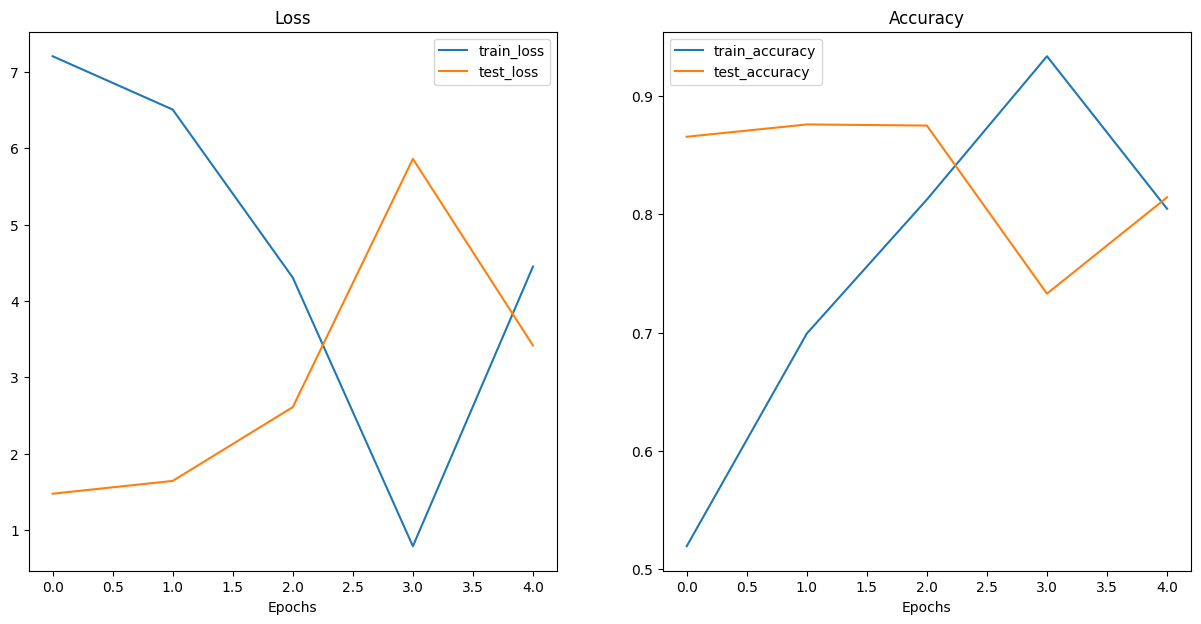

In [ ]:
try:
  from helper_functions import plot_loss_curves
except:
  print( "[INFO] Couldn't find helper_functions.py, downloading...")
  with open("helper_functions.py", "wb") as f:
    import requests
    request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
    print("Downloading helper_functions.py")
    f.write(request.content)
  from helper_functions import plot_loss_curves

# Plot the loss curves of our model
plot_loss_curves(results)

How does an ideal loss curves look like? - https://www.learnpytorch.io/04_pytorch_custom_datasets/#8-what-should-an-ideal-loss-curve-look-like

## 6. Make predictions on images from the test set or custom data

Some things to keep in mind when making predictions/inference on test data/custom data.

We have to make sure that our test/custom data is:
* `same shape` - images need to be same shape as model was trained on
* `same datatype` - custom data should be in the same data type
* `same device` - custom data/test data should be on the same device as the model
* `same transform` - if we've transformed our custom data, we will transform the test data and custom data the same.

> **Note:** These requirements go for all kinds of data if you're trying to make predictions with a trained model. Data you'd like to predict on should be in the same format as your model was trained on.

To do all of this, we'll create a function **`pred_and_plot_image()`** to:

1. Take in a trained model, a list of class names, a filepath to a target image, an image size, a transform and a target device.
2. Open an image with `PIL.Image.open()`.
3. Create a transform for the image (this will default to the manual_transforms we created above or it could use a transform generated from weights.transforms()).
4. Make sure the model is on the target device.
5. Turn on model eval mode with `model.eval()` (this turns off layers like `nn.Dropout()`, so they aren't used for inference) and the inference mode context manager.
6. Transform the target image with the transform made in step 3 and add an extra batch dimension with `torch.unsqueeze(dim=0)` so our input image has shape `[batch_size, color_channels, height, width]`.
7. Make a prediction on the image by passing it to the model ensuring it's on the target device.
8. Convert the model's output logits to prediction probabilities with `torch.softmax()`.
9. Convert model's prediction probabilities to prediction labels with `torch.argmax()`.
10. Plot the image with `matplotlib` and set the title to the prediction label from step 9 and prediction probability from step 8.


In [ ]:
from typing import List, Tuple

from PIL import Image

# 1. Take in a trained model, a list of class names, a filepath to a target image, an image size, a transform and a target device.
def pred_and_plot_image(model: torch.nn.Module,
                        image_path: str,
                        class_names : List[str],
                        image_size: Tuple[int,int] = (224,224),
                        transform: torchvision.transforms = None,
                        device: torch.device = device):
  # 2. Open image
  img = Image.open(image_path)

  # 3.Create a transform for the image (this will default to the manual_transforms we created above or it could use a transform generated from weights.transforms()).
  if transform is not None:
    image_transform = transform(img)
  else:
    image_transform = auto_transforms(img)

  # 4. Make sure the model is on the target device.
  model.to(device)

  # 5. Turn on model eval mode with model.eval()
  model.eval()

  # 6. Transform the target image with the transform made in step 3 and add an extra batch dimension with torch.unsqueeze(dim=0) so our input image has shape [batch_size, color_channels, height, width].
  with torch.inference_mode():
    # Add an extra dimension to the image
    target_image = image_transform.unsqueeze(dim=0)

    # 7. Make a prediction on the image by passing it to the model ensuring it's on the target device.
    target_image_pred = model(target_image.to(device))

  # 8. Convert the model's output logits to prediction probabilities with torch.softmax().
  target_image_pred_probs = torch.softmax(target_image_pred, dim=1)


  # 9. Convert model's prediction probabilities to prediction labels with torch.argmax().
  target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

  # 10. Plot the image with matplotlib and set the title to the prediction label from step 9 and prediction probability from step 8
  plt.figure()
  plt.imshow(img)
  plt.title(f"Pred: {class_names[target_image_pred_label.cpu()]} | Prob: {target_image_pred_probs.max().cpu():.3f}")
  plt.axis(False);



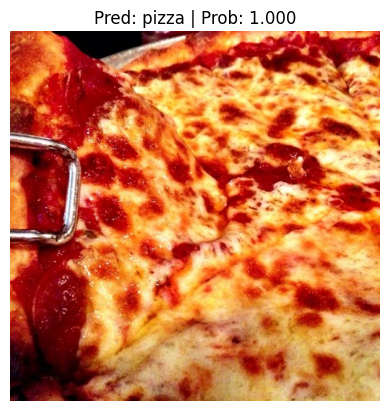

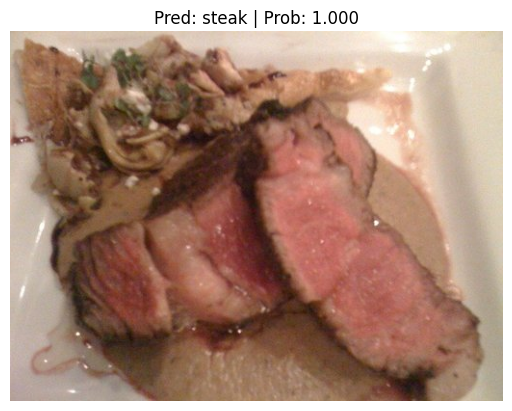

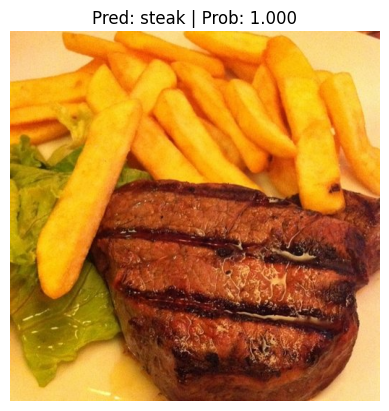

In [ ]:
# Get a random list of image paths from test set
import random
num_images_to_plot = 3
test_image_path_list = list(Path(test_dir).glob("*/*.jpg")) # get list all image paths from test data
test_image_path_sample = random.sample(population=test_image_path_list, # go through all of the test image paths
                                       k=num_images_to_plot) # randomly select 'k' image paths to pred and plot

# Make predictions on and plot the images
for image_path in test_image_path_sample:
    pred_and_plot_image(model=model,
                        image_path=image_path,
                        class_names=class_names,
                        # transform=weights.transforms(), # optionally pass in a specified transform from our pretrained model weights
                        image_size=(224, 224))

## 7. Let's predict with the custom image downloaded from the internet


In [ ]:
import requests

# Setup custom image path
custom_image_path = data_path/ "sushi.jpg"

# Check if image is present or else upload any image to check (pizza, sushi, steak)
if not custom_image_path.is_file():
  print("Image not present, uploading custom image from internet...")

else:
  print("Image already present, skipping upload...")


Image already present, skipping upload...


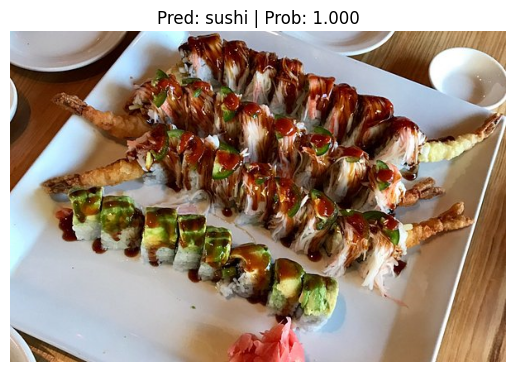

In [ ]:
### 7.1 Predicting our custom image
pred_and_plot_image(model=model,
                    image_path = custom_image_path,
                    class_names = class_names)